In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=20bce0910012e488ae07ea993a5cf786d879a4f47dc63303edeede4bb4ae9b20
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import os
from os.path import exists
import sys
import requests
import zipfile
import wget
#sys.path.append('../utility/')
#from  utility.Dataset import Dataset as ds
#from  utility.CNN import CNN as cnn
seed=42

In [4]:
cwd = os.getcwd()
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [34]:

import os
from os.path import exists
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
      train_dir='inaturalist_12K/train/' 
      test_dir='inaturalist_12K/val/'
     
      classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
      file_exists = exists(cwd+'/nature_12K.zip')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip')
        print('download Complete')
      extract_exists = exists(cwd+'/inaturalist_12K/')   
      if(extract_exists==False):  
        savePath=cwd
        savefile=cwd+'\\nature_12K.zip'
        print('Extracting..')
        with zipfile.ZipFile(savefile, 'r') as zip_ref:
            zip_ref.extractall(savePath)
        print('Complete')
       
        
    def showRandomImageOfEveryClass(self):
       classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
       imagePath='inaturalist_12K/train/'
       listImages=[]
       columns = 5
       rows = 5
       imcount=1
       
       for i in classes:
           p=imagePath+'/'+i
           files=os.listdir( p)
           img=random.choice(files)
           imgplt=mpimg.imread( p+'/'+str(img))
           imgplt=cv2.resize(imgplt,(128,128)) 
           listImages.append(imgplt)
           #plt.imshow(imgplt)
           #fig.add_subplot(rows, columns, imcount)
           #imcount+=1
           #plt.axis('off')
           #plt.title(i) 
       
       _, axs = plt.subplots(1, 10, figsize=(15, 15))
       axs = axs.flatten()
       for img, ax,cls in zip(listImages, axs,classes):
         
           ax.imshow(img)
           ax.axis('off')
           ax.set_title(str(cls))
       plt.show()
    
    
    def import_dataset(self,seed,image_size=128,augment_data=False):
        #All variables 
        cwd=""#os.getcwd()
        batchsize=32
        image_size=image_size
        train_dir = 'inaturalist_12K/train/'
        test_dir = 'inaturalist_12K/val/'
        print('Training Dataset')

        #perform Augmentation if augment_data=True
        if augment_data:
            train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
            test_datagen = ImageDataGenerator(rescale=1./255)
        else:
            train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
            test_datagen = ImageDataGenerator(rescale=1./255)

        train_ds = train_datagen.flow_from_directory(train_dir,subset="training", class_mode='sparse',color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        val_ds = train_datagen.flow_from_directory(train_dir,subset="validation",class_mode='sparse', color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        print('')
        print('Test Dataset')
        test_ds = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size),class_mode='sparse',color_mode='rgb',batch_size=30)

        return train_ds,val_ds, test_ds
               

In [41]:
"""
Following functions used to construct an CNN network

Parameters
---------
filters: number of filters in each layer.This is mendatory parameter
size_of_filters: Size of filters in each layers
BatchNormalization: If true apply batch normalisation after each layer
number_of_neurons_dense_layer : Dense layer neuron 
number_of_classes: Total number of classes
dropout: dropout rate
BatchNormalization: Whether batch normalization applied

filterSize: 
size of filter in first layer .mostly used only when filterOrganization selected

filterOrganization:
Some default configuaration selected.Optionally user can pass there own custom filter configuration from
"filters" parameter.This is optional parameter.Values are [all_same ,incr ,decr ,alt_incr ,alt_decr ]
               
all_same: [filterSize,filterSize,filterSize,filterSize,filterSize]
incr : [filterSize,filterSize*2,4*filterSize,8*filterSize,16*filterSize]
decr: =[filterSize,filterSize/2,filterSize/4,filterSize/8,filterSize/16]
alt_incr: =[filterSize,filterSize*2,filterSize,filterSize*2,filterSize]     
alt_decr: s=[filterSize,filterSize/2,filterSize,filterSize/2,filterSize]                
 
"""
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D,MaxPooling3D , Flatten , Dropout, Dense, Activation, BatchNormalization
class CNN:

    def train(self,model,train_ds,val_ds,epoch=10):
        model.compile(optimizer=tf.keras.optimizers.Adam(),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy'])
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
        hist=model.fit(train_ds, epochs=epoch,validation_data=val_ds)
        return model
    def setUp(self,filters, size_of_filters,\
            activation_function,\
            number_of_neurons_dense_layer=256,\
            number_of_classes=10,\
            dropout=0,\
            BatchNormalization=True,
            filterSize=32,
            filterOrganization=''
           ):
        imsize=128
        if(filterOrganization=='all_same'):
            filters=[filterSize,filterSize,filterSize,filterSize,filterSize]
        if(filterOrganization=='incr'):
            filters=[filterSize,filterSize*2,4*filterSize,8*filterSize,16*filterSize]
        if(filterOrganization=='decr'):
            filters=[filterSize,filterSize/2,filterSize/4,filterSize/8,filterSize/16]
        if(filterOrganization=='alt_incr'):
            filters=[filterSize,filterSize*2,filterSize,filterSize*2,filterSize]     
        if(filterOrganization=='alt_decr'):
            filters=[filterSize,filterSize/2,filterSize,filterSize/2,filterSize]

        model = Sequential()
        num_of_filters=len(filters)
        model.add(Conv2D(filters[0], size_of_filters[0],input_shape=(imsize,imsize,3)))
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
        model.add(MaxPooling2D((2,2)))

        for i in range(num_of_filters-1):
            model.add(Conv2D(filters[i+1], size_of_filters[i+1]))

            model.add(Activation(activation_function[i]))
            if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
            model.add(MaxPooling2D((2,2)))


        model.add(Flatten())

        model.add(Dense(number_of_neurons_dense_layer,activation=activation_function[-2])) 
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
        if(dropout>0):
            model.add(Dropout(dropout))
        model.add(Dense(number_of_classes, activation=activation_function[-1]))
        return model



In [36]:
ds=Dataset()

In [13]:
# download and extract  data set if not exits
!unzip nature_12K.zip



Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

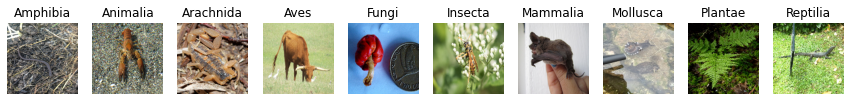

In [37]:
ds.showRandomImageOfEveryClass()

In [42]:
train_ds,val_ds,test_ds=ds.import_dataset(seed=42,augment_data=True)

Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.


In [43]:
#sample inputs
cnn=CNN()
no_of_filters = [16,32,64,128,256]
size_of_filters = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
activation_function = ['relu','relu','relu','relu','relu','relu','softmax']
number_of_neurons_in_the_dense_layer = 256
dropout=0.3
number_of_classes=10
model=cnn.setUp(no_of_filters,size_of_filters,\
          activation_function,\
          number_of_neurons_in_the_dense_layer,\
          number_of_classes,\
          dropout,\
          filterSize=16,\
         filterOrganization='incr') 

In [45]:
model=cnn.train(model,train_ds,val_ds,5)

Epoch 1/5
282/282 [==============================] - 338s 1s/step - loss: 2.3899 - accuracy: 0.2238 - val_loss: 3.1084 - val_accuracy: 0.1221
Epoch 2/5
282/282 [==============================] - 329s 1s/step - loss: 2.1452 - accuracy: 0.2701 - val_loss: 2.1677 - val_accuracy: 0.2763
Epoch 3/5
282/282 [==============================] - 323s 1s/step - loss: 2.0400 - accuracy: 0.2869 - val_loss: 2.0661 - val_accuracy: 0.3153
Epoch 4/5
282/282 [==============================] - 325s 1s/step - loss: 1.9682 - accuracy: 0.3128 - val_loss: 1.9391 - val_accuracy: 0.3253
Epoch 5/5
282/282 [==============================] - 327s 1s/step - loss: 1.9193 - accuracy: 0.3272 - val_loss: 1.9003 - val_accuracy: 0.3393


In [84]:
model.evaluate(test_ds)

67/67 [==============================] - 36s 541ms/step - loss: 1.9394 - accuracy: 0.3330


[1.939408302307129, 0.3330000042915344]

In [50]:
randomSamples=test_ds.subset
  

In [67]:

classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
imagePath='inaturalist_12K/val/'
listImages=[]
listLabels=[]
columns = 5
rows = 5
imcount=1
clsLabel=0
for i in classes:
    p=imagePath+'/'+i
    files=os.listdir( p)
    img1=random.choice(files)
    imgplt1=mpimg.imread( p+'/'+str(img1))
    imgplt1=cv2.resize(imgplt1,(128,128)) 
    listImages.append(imgplt1)
    img2=random.choice(files)
    imgplt2=mpimg.imread( p+'/'+str(img2))
    imgplt2=cv2.resize(imgplt2,(128,128)) 
    listImages.append(imgplt2)
    img3=random.choice(files)
    imgplt3=mpimg.imread( p+'/'+str(img3))
    imgplt3=cv2.resize(imgplt3,(128,128)) 
    listImages.append(imgplt3) 
    listLabels.append(clsLabel)
    listLabels.append(clsLabel)
    listLabels.append(clsLabel)
    clsLabel+=1



In [69]:
predictions=[]
for image in listImages:
  pred=model.predict(image.reshape(1,128,128,3)).argmax()
  predictions.append(pred)

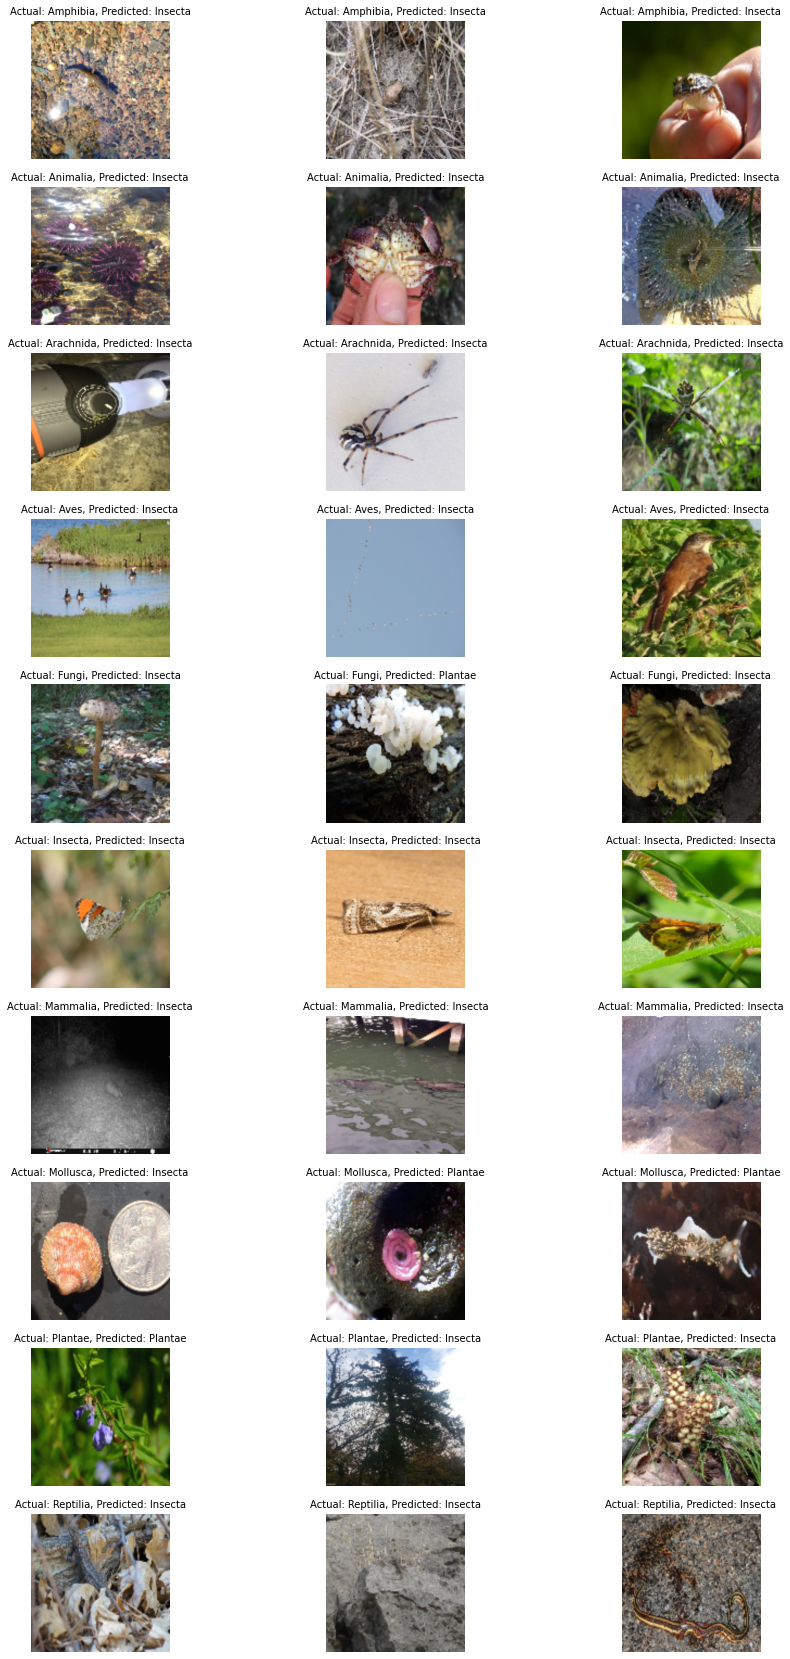

In [107]:

fig = plt.figure(figsize=(15,30))

for i in range(30):
  img=cv2.resize(listImages[i],(300,300))
  fig.add_subplot(10,3,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Actual: '+str(classes[listLabels[i]])+', Predicted: '+str(classes[predictions[i]]),fontdict={'fontsize':10})
  

In [127]:
#Iterate thru all the layers of the model
layer= model.layers[0]
weights, bias= layer.get_weights()
filters, biases = layer.get_weights()
#print(layer.name, filters.shape)

#normalize filter values between  0 and 1 for visualization
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  



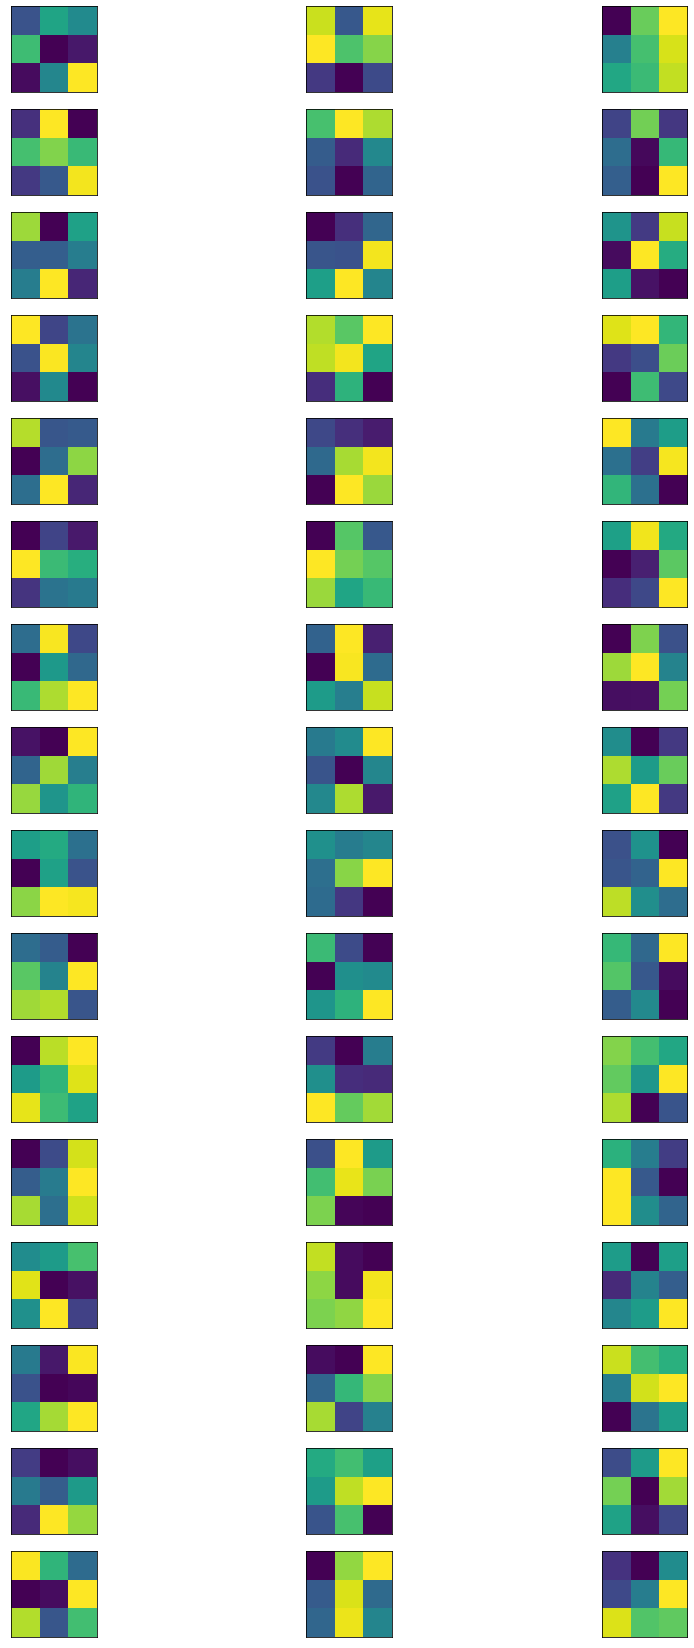

In [128]:
filter_cnt=1
fig = plt.figure(figsize=(15,30))
#plotting all the filters
for i in range(filters.shape[3]):
    #get the filters
    filt=filters[:,:,:, i]
    #plotting each of the channel, color image RGB channels
    for j in range(filters.shape[0]):
        ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filt[:,:, j])
        filter_cnt+=1
plt.show()

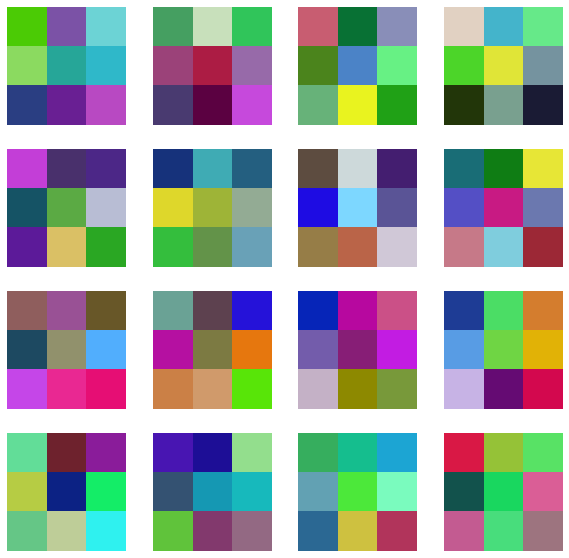

In [139]:
#The following plot shows the 16 filters in a 4x4 grid, with RGB channels combined.
filter_cnt=1
fig = plt.figure(figsize=(10,10))

#plotting all the filters
for i in range(filters.shape[3]):
    #get the filters
    filt=filters[:,:,:, i]
    fig.add_subplot(4,4,i+1)
   
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filt[:,:])
    filter_cnt+=1
    plt.axis('off')
plt.show()

In [ ]:

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )